# Tutorial: conformal prediction (regression)


In [1]:
import random
import numpy as np
import statsmodels as sm
import matplotlib.pyplot as plt

In [2]:
import seaborn as sns

In [3]:
colors_blindness = sns.color_palette("colorblind")

In [4]:
color_train = colors_blindness[1]
color_cal = colors_blindness[9]
color_test = colors_blindness[7] #(0,0,0) #colors_blindness[4]

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

1. [Data simulation: regression](#Data-simulation:-regression)
1. [Standard regression](#Standard-regression)
    1. [Data splitting](#data-splitting1)
    1. [Data preparation](#data-preparation1)
    1. [Fitting](#fitting1)
    1. [Prediction](#prediction1)
1. [Quantile regression](#Quantile-regression-(QR))
    1. [Fitting](#fitting2)
    1. [Prediction](#prediction2)
1. [Split Conformal Prediction (SCP): standard regression](#Split-Conformal-Prediction-(SCP):-standard-regression)
    1. [Data splitting & preparation](#data-splitting-(SCP))
    1. [Defining a score](#defining-a-score-(SCP))
    1. [Fitting](#fitting-(SCP))
    1. [Calibration scores](#calibration-scores-(SCP))
    1. [Prediction](#prediction-(SCP))
    1. [Coverage](#coverage-(SCP))
1. [Conformalized Quantile Regression (CQR)](#Conformalized-Quantile-Regression-(CQR))
    1. [Fitting](#fitting-(CQR))
    1. [Calibration scores](#calibration-scores-(CQR))
    1. [Prediction](#prediction-(CQR))
    1. [Coverage](#coverage-(CQR))
      
<!--1. [Split Conformal Prediction (SCP): classification](#Split-Conformal-(SCP):-classification)
    1. [Data splitting](#data-splitting-(SCP)-classif)
    1. [Data preparation](#data-preparation-(SCP)-classif)
    1. [Defining a score](#defining-a-score-(SCP)-classif)
    1. [Fitting](#fitting-(SCP)-classif)
    1. [Calibration scores](#calibration-scores-(SCP)-classif)
    1. [Prediction](#prediction-(SCP)-classif)
1. [Conformalized Quantile Regression (CQR): classification](#Conformalized-Quantile-Regression-(CQR):-classification)
    1. [Defining a score](#defining-a-score-(CQR)-classif)
    1. [Fitting](#fitting-(CQR)-classif)
    1. [Calibration scores](#calibration-scores-(CQR)-classif)
    1. [Prediction](#prediction-(CQR)-classif)-->



## Data simulation: regression

<div class="alert alert-block alert-info"> First we generate data $(X_i,Y_i)_i$ where $X_i \sim \mathcal{U}([0,1])$ and $Y_i\in\mathbb{R}$ (regression). </div> 

In [5]:
np.random.seed(42)

n = 300
X = np.random.uniform(low=0,high=5,size=n)
sigma = 1

## Homoscedastic model
# Y = np.cos(X) + sigma*np.random.normal(size=n)

## Heteroscedastic model
y = np.cos(X) + (1-np.cos(X))*sigma*np.random.normal(size=n)

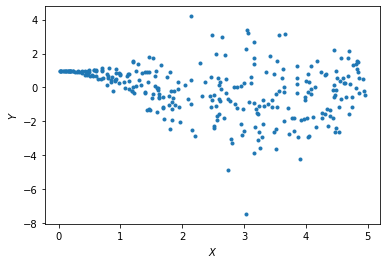

In [6]:
plt.scatter(X,y,marker='.')
plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')
plt.show()

# "Standard" regression

<div class="alert alert-block alert-info"> In this section, we aim at training a "standard" predictor: a polynomial regressor. To do so, we apply a polynomial transform to the data before training a classical linear model. </div> 


<div id="data-splitting1"> </div>

## Data splitting



In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.33, 
                                                    random_state=42)

<div id="data-preparation1"> </div>

## Data preparation

In [8]:
# Data preparation (embedding)

from sklearn.preprocessing import PolynomialFeatures


poly = PolynomialFeatures(4)
Xpoly_train = poly.fit_transform(X_train[:, np.newaxis])
Xpoly_test = poly.fit_transform(X_test[:, np.newaxis])


<div id="fitting1"> </div>

## Fitting

In [9]:
from sklearn.linear_model import LinearRegression

linear_reg = LinearRegression(fit_intercept=False)
linear_reg.fit(Xpoly_train,y_train)


LinearRegression(fit_intercept=False)

<div id="prediction1"></div>

## Prediction

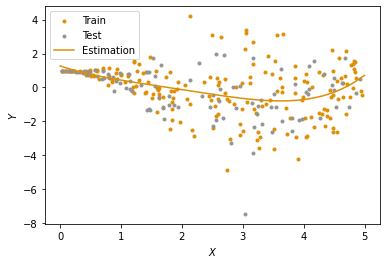

In [10]:
# Visualization
plt.scatter(X_train,y_train,marker='.',color=color_train,label="Train")
plt.scatter(X_test,y_test,marker='.',color=color_test,label="Test")
aux = np.linspace(0,5,500)
auxpoly = poly.fit_transform(aux[:, np.newaxis])
plt.plot(aux,linear_reg.predict(auxpoly),color=color_train,label="Estimation")
plt.legend()
plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')
plt.show()

In [11]:
# Some metrics of performance
y_pred = linear_reg.predict(Xpoly_test)
Rtwo_linear_reg = linear_reg.score(Xpoly_test,y_test)
print("R2 for linear regression (polynomial features): ",Rtwo_linear_reg)
RMSE_linear_reg = np.sqrt(np.mean((y_pred-y_test)**2))
print("RMSE for linear regression (polynomial features): ",RMSE_linear_reg)
RMSE_mean = np.sqrt(np.mean((np.mean(y_train)-y_test)**2))
print("RMSE for mean predictor: ",RMSE_mean)

R2 for linear regression (polynomial features):  0.2135705744567099
RMSE for linear regression (polynomial features):  1.2727821486358577
RMSE for mean predictor:  1.448787378633309


<div class="alert alert-block alert-success"> The polynomial regressor remains relevant compared to the baseline (mean predictor).  </div>

# Quantile regression (QR) 

<div class="alert alert-block alert-info"> 
    Quantile regression is a statistical technique used to estimate the conditional quantiles of a response variable given a set of predictor variables. Unlike traditional regression models that estimate the conditional mean of the response variable, quantile regression estimates the conditional median or other quantiles of the response variable.
For a quantile level $\beta$, learning a quantile regressor amounts to changing the risk to be minimized:
$
\begin{align}
\text{Risk}_{\beta}(f) = \mathbb{E}\left[ \text{pinball}_{\beta}(Y, f(X)) \right]
\end{align}
$
</div> 
    
<div class="alert alert-block alert-info"> In the following blocks, train two quantile regressors with quantile levels 0.05 and 0.95.
</div> 



<div id="fitting2"></div>

## Fitting (QR)



In [12]:
from sklearn.linear_model import QuantileRegressor

from sklearn.utils.fixes import sp_version, parse_version

## a good idea is to update scipy (!) to avoid problem of convergence
solver = "highs" if sp_version >= parse_version("1.6.0") else "interior-point"

beta = 0.1
qr_down = QuantileRegressor(quantile=beta/2, alpha=0,solver='highs')
qr_up = QuantileRegressor(quantile=1-beta/2, alpha=0,solver='highs')
qr_med = QuantileRegressor(quantile=0.5, alpha=0,solver='highs')
qr_down.fit(Xpoly_train, y_train)
qr_up.fit(Xpoly_train, y_train)
qr_med.fit(Xpoly_train, y_train)


QuantileRegressor(alpha=0, solver='highs')

<div id="prediction2"></div>

## Prediction (QR) 

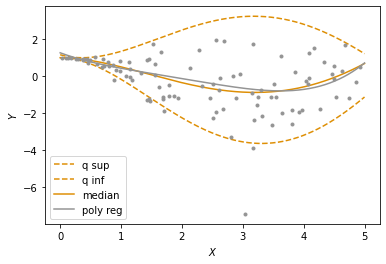

In [13]:
plt.plot(aux,qr_up.predict(auxpoly),'--',color=color_train,label="q sup")
plt.plot(aux,qr_down.predict(auxpoly),'--',color=color_train,label="q inf")
plt.plot(aux,qr_med.predict(auxpoly),'-',color=color_train,label="median")
plt.plot(aux,linear_reg.predict(auxpoly),'-',color=color_test,label="poly reg")
plt.scatter(X_test,y_test,marker='.',color=color_test,zorder=2)
plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')
plt.legend()
#plt.savefig('quantile_reg.pdf', bbox_inches='tight',dpi=300)
plt.show()

## What about coverage? (QR)

In [14]:
y_up_train = qr_up.predict(Xpoly_train)
y_up_test = qr_up.predict(Xpoly_test)
y_down_train = qr_down.predict(Xpoly_train)
y_down_test = qr_down.predict(Xpoly_test)

In [15]:
# Count how many times the true label was indeed 
# in the prediction interval on the test set

prop_covered_qr = np.sum((y_down_test<=y_test)*(y_test<=y_up_test))/len(y_test)
print("Theoretical coverage: ",1-beta)
print("Empirical coverage with QR: ",prop_covered_qr)

Theoretical coverage:  0.9
Empirical coverage with QR:  0.9292929292929293


<div class="alert alert-block alert-success"> The main advantage of quantile regression is that it provides a more complete picture of the relationship between the predictor variables and the response variable, especially in cases where the conditional distribution of the response variable is not symmetric
the tails of the distribution are of interest.
    
  While it has many strengths, there are also several limitations to consider when using this approach:

<ul>
    <li>Limited to Continuous Outcomes: Quantile regression is limited to modeling the relationship between a predictor variable and a continuous outcome variable, so it cannot be used for categorical or binary outcomes.</li>
    <li> Sensitivity to Outliers: The quantile regression method is sensitive to outliers in the data. It is recommended to check for outliers before fitting the model, and consider robust regression methods to mitigate the effects of outliers. </li>
    <li> Interpretation of Results: The interpretation of results can be challenging, especially for non-statisticians. Each quantile corresponds to a different conditional distribution of the outcome variable, which can make it difficult to summarize the overall effect of a predictor on the outcome.</li>
    <li> Sample Size: A large sample size is required for accurate estimation of the regression coefficients for each quantile. When the sample size is small, the estimates can be imprecise and unreliable.</li> 
    <li> Covariate Selection: Choosing which covariates to include in the model can be challenging, as the relationship between the outcome variable and each covariate may vary across different quantiles. It is recommended to use an iterative approach to model selection, considering both statistical significance and practical significance of the covariates.</li>
    </ul>

</div>

# Split Conformal Prediction (SCP): regression

<div class="alert alert-block alert-info">  The split conformal prediction procedure is a method for constructing prediction intervals for a new observation based on a training dataset. It involves splitting the training dataset into two parts: a <b>calibration</b> set and a <b>proper training</b> set.
    <ul>
        <li> The proper training set is used to train the model. </li> 
        <li> The <b>calibration</b> set is used to estimate the distribution of the error of the model. </li>
    </ul>
    <br>
    <br>
    The prediction interval is then constructed by combining the estimated error distribution with the prediction of the model for the new observation. This procedure ensures that the prediction interval is valid in the sense that it contains the true value of the new observation with a certain probability. 
</div>

<div id="data-splitting-(SCP)"> </div>

## Data splitting (need of a calibration set) + preparation (SCP)


In [16]:
from sklearn.model_selection import train_test_split

# Data splitting (achtung: overwriting on train data)
X_train, X_cal, y_train, y_cal = train_test_split(X_train, y_train, 
                                                  test_size=0.25, 
                                                  random_state=42)
Xpoly_train = poly.fit_transform(X_train[:, np.newaxis])
Xpoly_cal = poly.fit_transform(X_cal[:, np.newaxis])


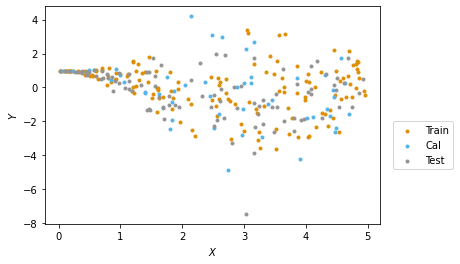

In [17]:
# Visualization

plt.figure()
plt.scatter(X_train,y_train,marker='.',color=color_train,label="Train")
plt.scatter(X_cal,y_cal,marker='.',color=color_cal,label="Cal")
plt.scatter(X_test,y_test,marker='.',color=color_test,label="Test")
plt.legend(loc=(1.04, 0.25))
plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')
plt.show()

<div id="defining-a-score-(SCP)"> </div>

## Defining a score (SCP)

In [18]:
def my_score(y_pred,y):
    return np.abs(y_pred-y)

<div id="fitting-(SCP)"> </div>

## Fitting (SCP)

In [19]:
linear_reg = LinearRegression(fit_intercept=False)
linear_reg.fit(Xpoly_train,y_train)

LinearRegression(fit_intercept=False)

<div id="calibration-scores-(SCP)"> </div>

## Calibration scores (SCP)

In [20]:
residuals_cal = my_score(linear_reg.predict(Xpoly_cal),y_cal)
n_cal = len(y_cal)
quantile_scp = np.quantile(residuals_cal,np.ceil((1-beta)*(n_cal+1))/n_cal)

<div id="prediction-(SCP)"> </div>

## Prediction (SCP)

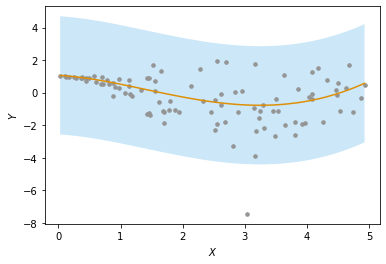

In [21]:
plt.scatter(X_test,y_test,marker='.',color=color_test,zorder=2, s=50)

y_pred_test = linear_reg.predict(Xpoly_test)
plt.plot(X_test[np.argsort(X_test)],y_pred_test[np.argsort(X_test)],color=color_train)
plt.fill_between(X_test[np.argsort(X_test)],
                 y_pred_test[np.argsort(X_test)]+quantile_scp,
                 y_pred_test[np.argsort(X_test)]-quantile_scp,
                 fc=color_cal,alpha=.3)
plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')
plt.show()

<div id="coverage-(SCP)"> </div>

## Coverage (SCP)

In [22]:
# Count how many times the true label was indeed 
# in the prediction interval on the test set

prop_covered_scp = np.sum(((y_pred_test-quantile_scp)<=y_test)*(y_test<=(y_pred_test+quantile_scp)))/len(y_test)
print("Theoretical coverage: ",1-beta)
print("Empirical coverage with QR: ",prop_covered_qr)
print("Empirical coverage with SCP: ",prop_covered_scp) ### WORST THAN QR with low n...

Theoretical coverage:  0.9
Empirical coverage with QR:  0.9292929292929293
Empirical coverage with SCP:  0.98989898989899


<div class="alert alert-block alert-success"> Split conformal prediction comes with a theoretical coverage guarantee (contrary to quantile regression).
    Some limitation to be noted are:
    <ul>
    <li>Dependence on data split: The performance of split conformal prediction can be heavily dependent on the particular data split used for training and validation. Different splits can result in different prediction intervals.</li>
    <li>Limited to exanchageable data (often i.i.d.): Split conformal prediction assumes that the data is exchangeable, which may not be the case for all data sets. </li>
    <li>Inefficient use of data: Split conformal prediction requires a separate validation set, which can reduce the amount of data available for training the model. This can be particularly problematic when data is limited or the model is complex.</li>
        <li> Split conformal prediction outputs <b>non-adaptive intervals</b> to the test point. 
    </ul>
</div>

<div id="Conformalized-Quantile-Regression-(CQR)"> </div>

# Conformalized Quantile Regression (CQR) 


<div class="alert alert-block alert-info">
Conformalized quantile regression is a statistical technique that combines the concepts of quantile regression and conformal prediction to provide prediction intervals that are valid with high probability (which is not the case when resorting to quantile regression only). This methods provides <b> adaptive </b> prediction sets to the test point in play. 
    
</div>

<div id="fitting-(CQR)"> </div>

## Fitting (CQR)

In [23]:
from sklearn.linear_model import QuantileRegressor

from sklearn.utils.fixes import sp_version, parse_version

## a good idea is to update scipy (!) to avoid problem of convergence
solver = "highs" if sp_version >= parse_version("1.6.0") else "interior-point"

beta = 0.1
qr_down = QuantileRegressor(quantile=beta/2, alpha=0,solver='highs')
qr_up = QuantileRegressor(quantile=1-beta/2, alpha=0,solver='highs')
qr_down.fit(Xpoly_train, y_train)
qr_up.fit(Xpoly_train, y_train)


#qr_med = QuantileRegressor(quantile=0.5, alpha=0,solver='highs')
#qr_med.fit(Xpoly_train, y_train)

QuantileRegressor(alpha=0, quantile=0.95, solver='highs')

<div id="calibration-scores-(CQR)"> </div>

## Calibration scores (CQR)

In [24]:
y_down_cal = qr_down.predict(Xpoly_cal)
y_up_cal = qr_up.predict(Xpoly_cal)
residuals_cal = np.maximum(y_cal-y_up_cal, y_down_cal-y_cal) #signed scores
n_cal = len(y_cal)
quantile_cqr = np.quantile(residuals_cal,np.ceil((1-beta)*(n_cal+1))/n_cal)

<div id="prediction-(CQR)"> </div>

## Prediction (CQR)

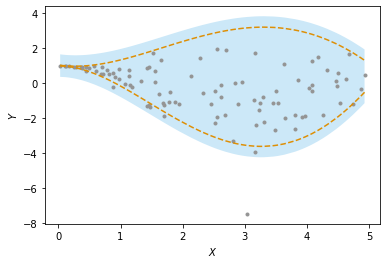

In [25]:
# prediction on test
y_down_test = qr_down.predict(Xpoly_test)
y_up_test = qr_up.predict(Xpoly_test)

# prediction interval
plt.scatter(X_test,y_test,marker='.',color=color_test,zorder=2)
plt.plot(X_test[np.argsort(X_test)],
         y_down_test[np.argsort(X_test)],
         '--',
         color=color_train)
plt.plot(X_test[np.argsort(X_test)],
         y_up_test[np.argsort(X_test)],
         '--',
         color=color_train)
plt.fill_between(X_test[np.argsort(X_test)],
                 y_up_test[np.argsort(X_test)]+quantile_cqr,
                 y_down_test[np.argsort(X_test)]-quantile_cqr,
                 fc=color_cal,alpha=.3)
plt.xlabel(r'$X$')
plt.ylabel(r'$Y$')
#plt.savefig('CQR_2.pdf', bbox_inches='tight',dpi=300)
plt.show()

<div id="coverage-(CQR)"> </div>

## Coverage (CQR)

In [26]:
# Count how many times the true label was indeed 
# in the prediction interval on the test set

prop_covered_cqr = np.sum(((y_down_test-quantile_cqr)<=y_test)*(y_test<=(y_up_test+quantile_cqr)))/len(y_test)
print("Theoretical coverage: ",1-beta)
print("Empirical coverage with QR: ",prop_covered_qr)
print("Empirical coverage with SCP: ",prop_covered_scp) 
print("Empirical coverage with CQR: ",prop_covered_cqr)


Theoretical coverage:  0.9
Empirical coverage with QR:  0.9292929292929293
Empirical coverage with SCP:  0.98989898989899
Empirical coverage with CQR:  0.98989898989899


In [27]:
quantile_cqr

0.6229301162363142

<div class="alert alert-block alert-success">
By providing data-dependent prediction interval, conformalized quantile regression is particularly adapted here, with such an heteroscedastic model.
</div>

# Improving the use of data: Jackknife+/CV

In [ ]:
## TO DO